In [ ]:
import warnings
from matcalc.relaxation import RelaxCalc
from matcalc.phonon import PhononCalc
from matcalc.eos import EOSCalc
from matcalc.elasticity import ElasticityCalc
from matcalc.utils import get_universal_calculator
from tqdm import tqdm
from time import perf_counter
import matplotlib.pyplot as plt

from mp_api.client import MPRester

warnings.filterwarnings("ignore", category=UserWarning, module="matgl")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="spglib")

/Users/aoo216/miniforge3/envs/uip_dev/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/Users/aoo216/miniforge3/envs/uip_dev/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [ ]:
mp_data = MPRester().materials.search(
    num_sites=(1, 8), fields=["material_id", "structure"], num_chunks=1, chunk_size=100
)

Retrieving MaterialsDoc documents:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
models = [(name, get_universal_calculator(name)) for name in ("M3GNet", "CHGNet", "MACE", "SevenNet")]

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
Using Materials Project MACE for MACECalculator with /Users/aoo216/.cache/mace/5yyxdm76
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


In [ ]:
fmax = 0.1
opt = "BFGSLineSearch"

In [ ]:
prop_preds = []

for dct in (pbar := tqdm(mp_data[:10])):  # Here we just do a sampling of 20 structures.
    mat_id, formula = dct.material_id, dct.structure.formula
    pbar.set_description(f"Running {mat_id} ({formula})")
    model_preds = {"material_id": mat_id, "formula": formula, "nsites": len(dct.structure)}

    for model_name, model in models:
        # The general principle is to do a relaxation first and just reuse the same structure.
        prop_calcs = [
            ("relax", RelaxCalc(model, fmax=fmax, optimizer=opt)),
            ("elastic", ElasticityCalc(model, fmax=fmax, relax_structure=False)),
            ("eos", EOSCalc(model, fmax=fmax, relax_structure=False, optimizer=opt)),
            ("phonon", PhononCalc(model, fmax=fmax, relax_structure=False)),
        ]
        properties = {}
        for name, prop_calc in prop_calcs:
            start_time = perf_counter()
            properties[name] = prop_calc.calc(dct.structure)
            if name == "relax":
                # Replace the structure with the one from relaxation for other property computations.
                struct = properties[name]["final_structure"]
            model_preds[f"time_{name}_{model_name}"] = perf_counter() - start_time
        model_preds[model_name] = properties
    prop_preds.append(model_preds)

Running mp-1183126 (Ac6 Pa2):  40%|████      | 4/10 [00:34<00:49,  8.32s/it]    /Users/aoo216/miniforge3/envs/uip_dev/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Running mp-1183091 (Ac3 Er1):  80%|████████  | 8/10 [01:47<00:31, 15.99s/it]    /Users/aoo216/miniforge3/envs/uip_dev/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Running mp-985294 (Ac6 Er2):  90%|█████████ | 9/10 [01:54<00:13, 13.20s/it] /Users/aoo216/miniforge3/envs/uip_dev/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Running mp-985294 (Ac6 Er2): 100%|██████████| 10/10 [02:12<00:00, 13.30s/it]


In [ ]:
import pandas as pd

df_preds = pd.DataFrame(prop_preds)
for model_name, _ in models:
    df_preds[f"time_total_{model_name}"] = (
        df_preds[f"time_relax_{model_name}"]
        + df_preds[f"time_elastic_{model_name}"]
        + df_preds[f"time_phonon_{model_name}"]
        + df_preds[f"time_eos_{model_name}"]
    )

In [ ]:
df_preds

,material_id,formula,nsites,time_relax_M3GNet,time_elastic_M3GNet,time_eos_M3GNet,time_phonon_M3GNet,M3GNet,time_relax_CHGNet,time_elastic_CHGNet,...,MACE,time_relax_SevenNet,time_elastic_SevenNet,time_eos_SevenNet,time_phonon_SevenNet,SevenNet,time_total_M3GNet,time_total_CHGNet,time_total_MACE,time_total_SevenNet
0,mp-1185285,Li1 Ac1 Hg2,4,0.179908,0.395948,0.158950,0.457419,{'relax': {'final_structure': [[4.86550446e-10...,0.770768,0.901978,...,{'relax': {'final_structure': [[-8.17372327e-1...,3.551356,0.862325,0.377756,0.673511,{'relax': {'final_structure': [[-5.03999980e-1...,1.192226,3.177015,2.050734,5.464948
1,mp-1183106,Ac2 Zn1 In1,4,0.064066,0.345367,0.137018,0.362495,{'relax': {'final_structure': [[6.06572054 6.0...,0.178992,1.088711,...,{'relax': {'final_structure': [[6.04095565 6.0...,0.116898,0.851800,0.346552,0.777812,{'relax': {'final_structure': [[6.05161229 6.0...,0.908947,2.101789,1.587914,2.093062
2,mp-976333,Li2 Ac1 Tl1,4,0.061562,0.362518,0.168136,0.422129,{'relax': {'final_structure': [[3.64137795 3.6...,0.169795,1.320697,...,{'relax': {'final_structure': [[3.66049425 3.6...,0.116019,0.873783,0.488225,0.861443,{'relax': {'final_structure': [[3.66937764 3.6...,1.014346,2.304504,1.845336,2.339471
3,mp-1006278,Ac1 Eu1 Au2,4,0.062681,0.470774,0.190595,0.724072,{'relax': {'final_structure': [[1.91530262 1.9...,0.158874,0.891152,...,{'relax': {'final_structure': [[1.92353817 1.9...,0.174726,0.870296,0.387393,1.596638,{'relax': {'final_structure': [[1.92611981 1.9...,1.448122,1.818746,2.159440,3.029053
4,mp-1183126,Ac6 Pa2,8,0.215847,0.786029,0.488486,3.176752,{'relax': {'final_structure': [[1.96886769 1.1...,1.088008,0.931740,...,{'relax': {'final_structure': [[1.9658535 1.1...,0.798185,1.476761,1.289990,9.026947,{'relax': {'final_structure': [[2.19924826 1.2...,4.667114,5.207478,8.064815,12.591883
5,mp-862894,Ac1 Sb1 Au2,4,0.021436,0.379669,0.180021,0.733265,{'relax': {'final_structure': [[1.85504146 1.8...,0.191379,0.911154,...,{'relax': {'final_structure': [[1.86906772 1.8...,0.118193,0.887130,0.645211,1.655511,{'relax': {'final_structure': [[1.86324869 1.8...,1.314391,2.030083,2.222206,3.306045
6,mp-1183483,Ca1 Ac1 Rh2,4,0.068735,0.552808,0.390350,0.586251,{'relax': {'final_structure': [[-1.03568812e-0...,0.231274,1.793239,...,{'relax': {'final_structure': [[ 6.11145551e-0...,0.177436,0.959991,0.536055,0.767170,{'relax': {'final_structure': [[-2.11033340e-0...,1.598144,3.157331,2.336888,2.440652
7,mp-865927,Ac1 Ti1 O3,5,0.116444,0.692389,0.263422,1.947618,{'relax': {'final_structure': [[ 9.95343002e-0...,1.773215,2.825814,...,{'relax': {'final_structure': [[6.55694231e-07...,0.305844,1.888603,0.730328,3.835169,{'relax': {'final_structure': [[-3.47724905e-0...,3.019872,9.863845,4.026829,6.759943
8,mp-1183091,Ac3 Er1,4,0.062263,0.362763,0.140972,0.374515,{'relax': {'final_structure': [[-1.98345271e-1...,0.416839,0.931550,...,{'relax': {'final_structure': [[6.87753743e-17...,0.143445,0.811348,0.322289,0.849400,{'relax': {'final_structure': [[1.09445687e-08...,0.940513,2.574678,1.418321,2.126482
9,mp-985294,Ac6 Er2,8,0.115057,0.902221,0.341118,1.960483,{'relax': {'final_structure': [[1.98024928 1.1...,0.361165,0.955471,...,{'relax': {'final_structure': [[1.98193275 1.1...,0.414758,1.758671,0.787659,4.877613,{'relax': {'final_structure': [[1.96960666 1.1...,3.318878,2.524054,5.065297,7.838701


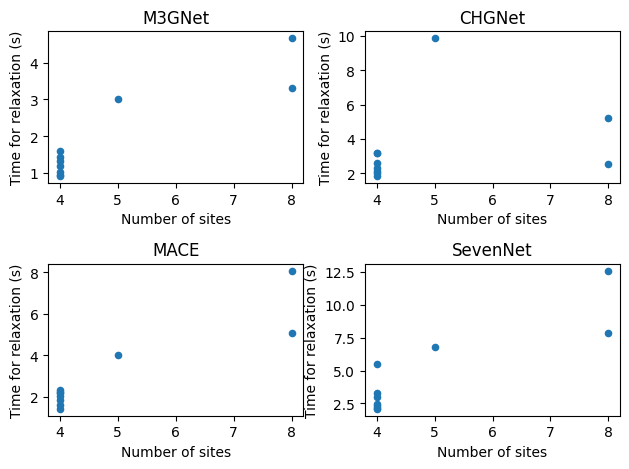

In [ ]:

fig,axes = plt.subplots(2,2)
axes = axes.flatten()
for i, (model_name, model) in enumerate(models):
    ax = axes[i]
    df_preds.plot(x="nsites", y=f"time_total_{model_name}", kind="scatter", ax=ax)
    ax.set_xlabel("Number of sites")
    ax.set_ylabel("Time for relaxation (s)")
    ax.set_title(model_name)

plt.tight_layout()
plt.show()



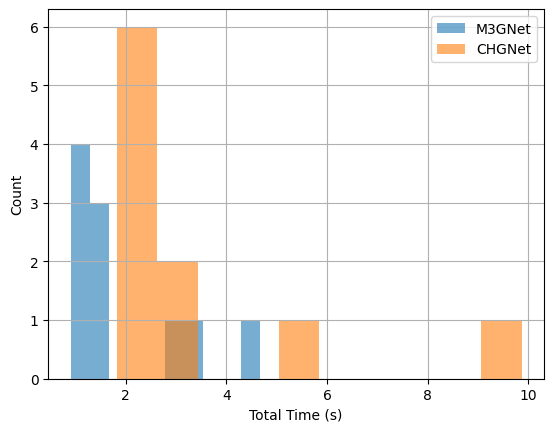

In [ ]:

for model_name, _ in models[:2]:
    ax = df_preds[f"time_total_{model_name}"].hist(label=model_name,alpha=0.6)

ax.set_xlabel("Total Time (s)")
ax.set_ylabel("Count")
ax.legend()
plt.show()